# Culvert Performance Curve Validation

This notebook shows a method to validate culverts in swmm/xpswmm models using the HY8 results, I will explore more on the theory side in another post, here I am just focusing on the tooling and procedures.

# Performance Curve

[HY-8 Culvert Hydraulic Analysis Program](https://www.fhwa.dot.gov/engineering/hydraulics/software/hy8/) can calculate culvert performance curves uisng the [FWHA HDS5 ](https://www.fhwa.dot.gov/engineering/hydraulics/pubs/12026/hif12026.pdf) methods. An example is shown below.



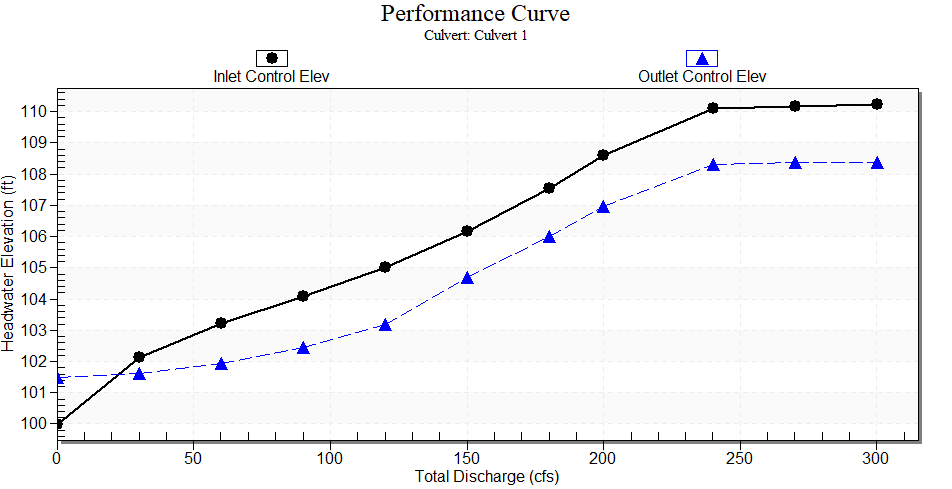

I write a few scripts in this notebook to automate the process of comparing the modeling results to the HY8 results.

Major steps are,

- Setup the HY8 culvert model, and create the discharge vs inlet/outlet table
- Setup the swmm5 model, and run the model
- Setup the XPSWMM model, and create results table.

# Setup HY8 Culvert Model

Setting up a culvert model in HY8 is farily straight forward.

The model is saved to : **./data/hy8/hds5_example.hy8**


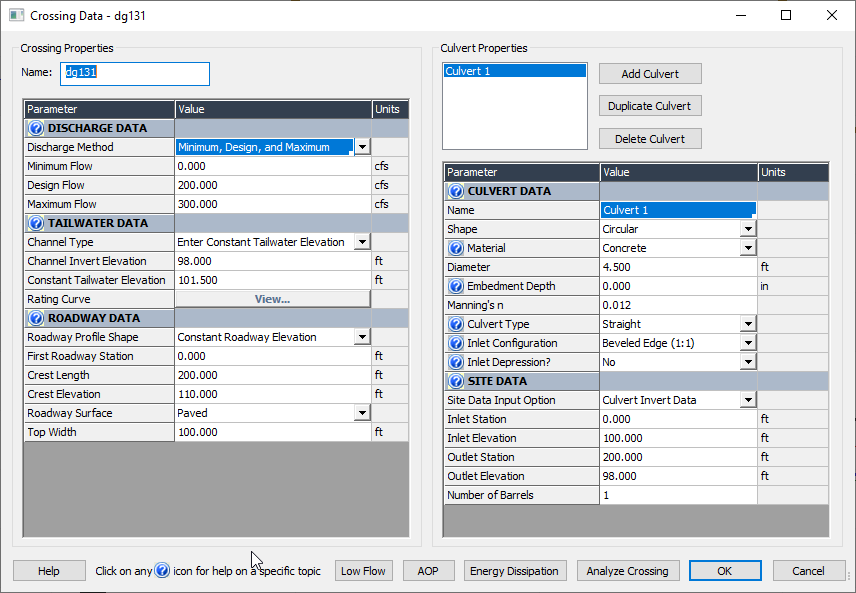

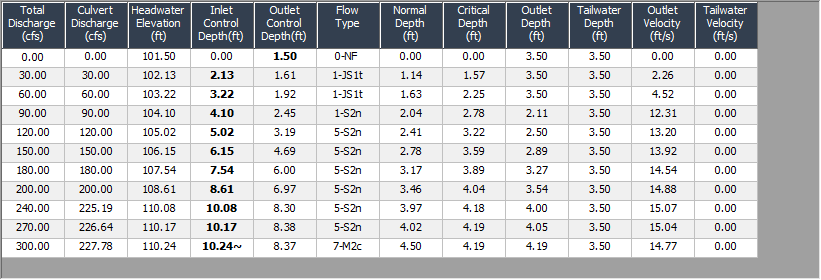

# Setup SWMM5 Model

A swmm5 model is created: 

Model: **./data/swmm5/dg131.inphds5_example2.inp**

- For the culvert, I didn't set any losses, I am hoping entering the culvert code should handle all these automatically.
- I loaded a hydrograph from 0 - 300 cfs in 6 hours.
- The depth vs total inflow in node 54RCP_2 should give the performance curve
- added 3.5ft tail water at outlet
- Had to use a hotstart file to get the starting level correct

# Setup an XPSWMM Model

Import the xpx file into XPSWMM and run the model

Model:**./data/xpswmm/dg131.xpx**

# Create xpswmm results table

Export the node stage and link flow to a csv file.

- graph the node, export the stage time series
- graph the link, export the flow time series

The results are saved in : **./data/xpsmm/dg131.csv**




# The scripts

I used the following scripts to,
- read the csv files from hy8, xpswmm results
- run swmm5 file and extract results
- plot the performance curves

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
lib_path = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\source'
if lib_path not in sys.path:
    sys.path.append(lib_path)
sys.path

import swmm_tools as st

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_performance_curve(hy8_curve_csv, swmm5_out, xpswmm_csv):
    df = pd.read_csv(hy8_curve_csv)
    df_swmm = st.extract_node(swmm5_out, '4')
    df_xp = pd.read_csv(xpswmm_csv)
    ax = df.plot(x='q', y='inlet', label='Inlet', style='x-', figsize=(10,10))
    ax = df.plot(x='q', y='outlet', label='Outlet', style='.-', ax=ax)
    ax = df_swmm.plot(x='total_flow', y='depth', label='SWMM5', style='o-', ax=ax)
    ax.fill_between(df_swmm['total_flow'], df_swmm['depth']*0.9, df_swmm['depth']*1.1, alpha=0.2)
    ax = df_xp.plot(x='q', y='xpswmm', label='XPSWMM', style='o-', ax=ax)
    plt.xlabel('Discharge(cfs)')
    plt.ylabel('Headwater(ft)')
    plt.title('SWMM5 culvert vs HY8')
    plt.grid(True)
    plt.show()
    

# Compare

You need to update the path to each file in the code block below. Run it and it will plot the results.

4


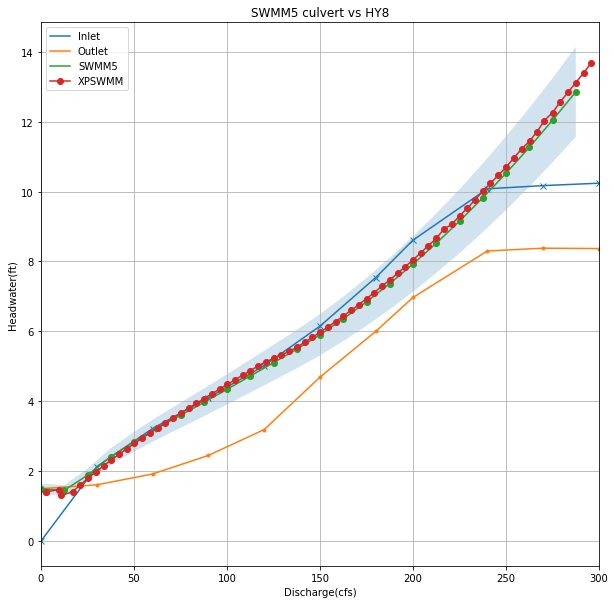

In [6]:
ws = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\references\culvert\data'
swmm5_out = os.path.join(ws, 'swmm5/dg131.out')
hy8_curve_csv = os.path.join(ws, 'hy8/dg131_performance_curve.csv')
xpswmm_csv = os.path.join(ws, 'xpswmm/dg131.csv')

compare_performance_curve(hy8_curve_csv, swmm5_out, xpswmm_csv)

The comparison is shown above,
- X is the discharge, Y is the head water depth
- the green line is swmm5 results
- the shaded area is the 90-110% for the swmm5 simulated curve
- the orange is the inlet curve
- the blue is the outlet curve
- the red curve is XPSWMM result

The conclusions,
- the culvert performance curve is the higher of the inlet/outlet curve
- other than <50cfs, the culvert is inlet control, for inlet control both swmm5/xpswmm seems to be very close to the HY8 results
- for the design flow 200cfs, both XPSMWW and SWMM shows very similar results within 10% to HY8
- SWMM5 showed stability issues for areas > 250 cfs
- XPSWMM doesn't seem to switch to the outlet control for areas < 50 cfs

For design purposes, the results look pretty good for the region around 200 cfs. 

In the next post, I'll see how things will work out if it is an outlet control condition.
